# Sprint 機械学習スクラッチ　ロジスティック回帰

In [226]:
#基本ライブラリ
import pickle
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
%matplotlib inline

## 【問題1】仮定関数

ロジスティック回帰の仮定関数のメソッドをScratchLogisticRegressionクラスに実装する。

ロジスティック回帰の仮定関数は、線形回帰の仮定関数を シグモイド関数 に通したものとなる。

- シグモイド関数

$$
g(z) = \frac{1}{1+e^{-z}}
$$

線形回帰の仮定関数は

$$
h_θ(x) = θ^T \cdot x
$$

なので、まとめて書くと、ロジスティック回帰の仮定関数は

$$
h_θ(x) = \frac{1}{1 + e^{-θ^T \cdot x}}
$$

となる。

- x：特徴量ベクトル
- θ：パラメータ（重み）ベクトル

### 具体的な値で処理の流れを確認

In [2]:
#検証のためにシード値の設定
np.random.seed(seed=32)

#サンプルデータ
X = np.array([[1,2,3], [4,5,6], [7,8,9], [10,11,12], [13,14,15]])

#線形回帰を行う際に、wx0のバイアス項を新規にデータに加える
bias = np.ones(X.shape[0]).reshape(X.shape[0],1)
X = np.concatenate([bias, X], 1)

#暫定のシータ値を生成する
theta = np.full(X.shape[1], np.random.rand())
print("シータ初期値=", theta)
print("theta.shape", theta.shape)

#暫定シータ値をもとに仮定値を生成する
h = np.dot(theta, X.T)

#ドット積なので、行列の形が合わないとエラーが出る
#h2 = np.dot(theta.T, X)

print("theta.T=", theta.T)
print("theta.T.shape=", theta.T.shape)
print("X",X)
print("X.T",X.T)

#ドット積の具体的な中身は以下
print("----手動計算----")
print("h_0 =",theta[0]*X[0,0]+theta[1]*X[0,1]+ theta[2]*X[0,2]+ theta[3]*X[0,3])
print("h_1 =",theta[0]*X[1,0]+theta[1]*X[1,1]+ theta[2]*X[1,2]+ theta[3]*X[1,3])
print("h_2 =",theta[0]*X[2,0]+theta[1]*X[2,1]+ theta[2]*X[2,2]+ theta[3]*X[2,3])
print("h_3 =",theta[0]*X[3,0]+theta[1]*X[3,1]+ theta[2]*X[3,2]+ theta[3]*X[3,3])
print("h_4 =",theta[0]*X[4,0]+theta[1]*X[4,1]+ theta[2]*X[4,2]+ theta[3]*X[4,3])

print("仮定関数 =", h)

df = pd.DataFrame(X)
df

シータ初期値= [0.85888927 0.85888927 0.85888927 0.85888927]
theta.shape (4,)
theta.T= [0.85888927 0.85888927 0.85888927 0.85888927]
theta.T.shape= (4,)
X [[ 1.  1.  2.  3.]
 [ 1.  4.  5.  6.]
 [ 1.  7.  8.  9.]
 [ 1. 10. 11. 12.]
 [ 1. 13. 14. 15.]]
X.T [[ 1.  1.  1.  1.  1.]
 [ 1.  4.  7. 10. 13.]
 [ 2.  5.  8. 11. 14.]
 [ 3.  6.  9. 12. 15.]]
----手動計算----
h_0 = 6.012224871051278
h_1 = 13.742228276688635
h_2 = 21.472231682325994
h_3 = 29.20223508796335
h_4 = 36.93223849360071
仮定関数 = [ 6.01222487 13.74222828 21.47223168 29.20223509 36.93223849]


,0,1,2,3
0,1.0,1.0,2.0,3.0
1,1.0,4.0,5.0,6.0
2,1.0,7.0,8.0,9.0
3,1.0,10.0,11.0,12.0
4,1.0,13.0,14.0,15.0


In [3]:
#仮定関数をシグモイド関数に通す

g = 1/(1+ np.exp(-h))

print(g)

[0.99755735 0.99999892 1.         1.         1.        ]


## 【問題2】最急降下法

最急降下法により学習させる実装を行なう。以下の式で表されるパラメータの更新式のメソッド_gradient_descentを追加し、fit
メソッドから呼び出すようにする。

$$
        θ_j := θj - α\frac{∂J(θ)}{∂θ_j} \\
        \frac{∂J(θ)}{∂θ_0} = \frac{1}{m}\sum_{i=1}^{m}(h_θ(x^{(i)}) - y^{(i)})x_j^{(i)}  , j=0 \\
        \frac{∂J(θ)}{∂θ_j} = (\frac{1}{m}\sum_{i=1}^{m}(h_θ(x^{(i)}) - y^{(i)})x_j^{(i)} ) + \frac{\lambda}{m}θ_j , j \geq1
$$

## 完成版クラス

In [323]:
class ScratchLogisticRegression():
    """
    ロジスティック回帰のスクラッチ実装

    Parameters
    ----------
    num_iter : int
      イテレーション数
    lr : float
      学習率
    no_bias : bool
      バイアス項を入れない場合はTrue
    verbose : bool
      学習過程を出力する場合はTrue

    Attributes
    ----------
    self.coef_ : 次の形のndarray, shape (n_features,)
      パラメータ
    self.loss : 次の形のndarray, shape (self.iter,)
      学習用データに対する損失の記録
    self.val_loss : 次の形のndarray, shape (self.iter,)
      検証用データに対する損失の記録

    """

    def __init__(self, num_iter=5000, lr=0.001, bias=False, verbose=False, lam=1):
        # ハイパーパラメータを属性として記録
        self.iter = num_iter
        self.lr = lr
        self.bias = bias
        self.verbose = verbose
        self.lam = lam
        # 損失を記録する配列を用意
        self.loss = np.array([])
        self.val_loss = np.array([])
        # 予測値を閾値処理する前のデータ
        self.val_pred = np.array([])

    def fit(self, X, y, X_val=None, y_val=None):
        """
        ロジスティック回帰を学習する。検証用データが入力された場合はそれに対する損失と精度もイテレーションごとに計算する。

        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
            学習用データの特徴量
        y : 次の形のndarray, shape (n_samples, )
            学習用データの正解値
        X_val : 次の形のndarray, shape (n_samples, n_features)
            検証用データの特徴量
        y_val : 次の形のndarray, shape (n_samples, )
            検証用データの正解値
        """
        #バイアス項の生成
        if not self.bias:
            bias_term = np.ones(X.shape[0]).reshape(X.shape[0],1)
            X = np.concatenate([bias_term, X], 1)
        
        #サンプル数と同数の１配列を作成（目的関数で使用）
        all_one_vector = np.ones(X.shape[0])
        
        #シータの初期値
        self.coef_ = np.full(X.shape[1], np.random.rand())
        #print(self.coef_)    #シータの初期値を確認
        
        for i in range(self.iter):
            g = self._linear_hypothesis(X, self.coef_)    #仮定の生成（シグモイド処理）
            error = g - y    #errorの算出
            #print("error=", error)             #errorの確認
            self._gradient_descent(X, error)    #θの更新
            
            #損失関数の更新
            inside_sigma = (-y)*np.log(g) - (all_one_vector - y)*np.log(all_one_vector - g)
            self.loss = np.append(self.loss,
                                  np.sum(inside_sigma)/X.shape[0] + self.lam*np.sum(self.coef_**2)/(2*X.shape[0])
                                 )
        
        #print("coef_", self.coef_)
        
        #検証用
        if X_val is not None and y_val is not None:
            if not self.bias:
                bias_term = np.ones(X_val.shape[0]).reshape(X_val.shape[0],1)
                X_val = np.concatenate([bias_term, X_val], 1)
            
            #サンプル数と同数の１配列を作成（目的関数で使用）
            all_one_vector = np.ones(X_val.shape[0])
            
            self.coef_val_ = np.full(X_val.shape[1], np.random.rand())
            #print(self.coef_val_)    #シータの初期値を確認
            
            for i in range(self.iter):
                g = self._linear_hypothesis(X_val, self.coef_val_)    #仮定の生成
                error = g - y_val    #errorの算出
                #print("error=", error)             #erroeの確認
                self._gradient_descent_val(X_val, error)    #θの更新
                
                #損失関数の更新
                inside_sigma = (-y_val)*np.log(g) - (1 - y_val)*np.log(1 - g)
                self.val_loss = np.append(self.val_loss,
                                      np.sum(inside_sigma)/X_val.shape[0] + self.lam*np.sum(self.coef_val_**2)/(2*X_val.shape[0])
                                     )

 
        if self.verbose:
            #verboseをTrueにした際は学習過程を出力
            print()
        pass


    def predict(self, X):
        """
        ロジスティック回帰を使いラベルを推定する。

        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
            サンプル

        Returns
        -------
            次の形のndarray, shape (n_samples, 1)
            ロジスティック回帰による推定結果
        """

        pass
        return

    def predict_proba(self, X):
        """
        ロジスティック回帰を使い確率を推定する。

        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
            サンプル

        Returns
        -------
            次の形のndarray, shape (n_samples, 1)
            ロジスティック回帰による推定結果
        """
        #バイアス項の生成
        if not self.bias:
            p_bias = np.ones(X.shape[0]).reshape(X.shape[0],1)
            X = np.concatenate([p_bias, X], 1)
        
        #推定
        p = np.dot(self.coef_, X.T)
        g = 1/(1+ np.exp(-p))
        self.val_pred = g
        
        #閾値処理
        f = np.vectorize( lambda x: 1 if x > 0.5 else 0)
        g_threshold = f(g)
        
        #np.whereでも実装できる

        return g_threshold

    def _linear_hypothesis(self, X, coef):
        """
        線形の仮定関数を計算し、シグモイド関数に通す

        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features+bias)
          学習データ

        Returns
        -------
          次の形のndarray, shape (n_samples, 1)
          線形の仮定関数による推定結果

        """
        h = np.dot(coef, X.T)
        g = 1/(1+ np.exp(-h))
        
        return g
    
    def _gradient_descent(self, X, error):
        """
        誤差からθの差分を偏微分によって算出し、新しいθを生み出す
        
        Parameters
        -----------------
        X : 次の形のndarray, shape (n_samples, n_features+bias)
          学習データ
        error：目的値と仮定値の差分（ベクトル）
        
        Returns
        -----------
        θの更新なので、返り値はいらない
        """
        error_calc = error.reshape(-1,1)*X   #偏微分
        error_sum = error_calc.sum(axis=0)    #特徴量ごとに足す
        if self.bias:
            #バイアス項を追加しない場合
            self.coef_ = self.coef_ - self.lr*((error_sum/X.shape[0]) + (self.lam*self.coef_/X.shape[0]))
        else:
            #バイアス項を追加している場合（デフォルト）
            #切片には正則化をかけない
            self.coef_[0] = self.coef_[0] - self.lr*(error_sum[0]/X.shape[0])
            self.coef_[1:] = self.coef_[1:] - self.lr*((error_sum[1:]/X.shape[0]) + (self.lam*self.coef_[1:]/X.shape[0]))
            
    def _gradient_descent_val(self, X, error):
        """
        誤差からθの差分を偏微分によって算出し、新しいθを生み出す
        
        Parameters
        -----------------
        X : 次の形のndarray, shape (n_samples, n_features+bias)
          学習データ
        error：目的値と仮定値の差分（ベクトル）
        
        Returns
        -----------
        θの更新なので、返り値はいらない
        """
        error_calc = error.reshape(-1,1)*X   #偏微分
        error_sum = error_calc.sum(axis=0)    #特徴量ごとに足す
        if self.bias:
            #バイアス項を追加しない場合
            self.coef_val_ = self.coef_val_ - self.lr*((error_sum/X.shape[0]) + (self.lam*self.coef_val_/X.shape[0]))
        else:
            #バイアス項を追加している場合（デフォルト）
            #切片には正則化をかけない
            self.coef_val_[0] = self.coef_val_[0] - self.lr*(error_sum[0]/X.shape[0])
            self.coef_val_[1:] = self.coef_val_[1:] - self.lr*((error_sum[1:]/X.shape[0]) + (self.lam*self.coef_val_[1:]/X.shape[0]))
    
    def save_coef(self, file_path, val_loss=False):
        """
        重みをpickle化して保存するための関数
        
        Parameters
        ----------
        path : 読み込みファイルのパス
        val_loss：検証用の重みを読み込む場合Trueにする
        """
        with open(file_path, mode='wb') as f:
            if val_loss:
                pickle.dump(self.coef_val_)
                print("coef_val File Saved")
            else:
                pickle.dump(self.coef_, f)
                print("coef File Saved")
            
    def load_coef(self, file_path, val_loss=False):
        """
        pickle化した重みを読み込む
        
        Parameters
        ----------
        path : 読み込みファイルのパス
        val_loss：検証用の重みを読み込む場合Trueにする
        """
        with open(file_path, mode='rb') as f:
            if val_loss:
                self.coef_val_ = pickle.load(f)
                print("coef_val File Loaded")
            else:
                self.coef_ = pickle.load(f)
                print("coef File Loaded")

In [99]:
#検証のためにシード値の設定
np.random.seed(seed=32)

#サンプルデータ
X = np.array([[1,2,3], [4,5,6], [7,8,9], [10,11,12], [13,14,15]])
y = np.array([0,1,0,1,0])

LoR = ScratchLogisticRegression()
LoR.fit(X,y)

error= [ 9.97557347e-01 -1.07603308e-06  1.00000000e+00 -2.07833750e-13
  1.00000000e+00]
error= [ 9.97473877e-01 -1.16741859e-06  9.99999999e-01 -2.48023824e-13
  1.00000000e+00]
error= [ 9.97387613e-01 -1.26650402e-06  9.99999999e-01 -2.96207503e-13
  1.00000000e+00]
error= [ 9.97298462e-01 -1.37393292e-06  9.99999999e-01 -3.53495011e-13
  1.00000000e+00]
error= [ 9.97206333e-01 -1.49040218e-06  9.99999999e-01 -4.21884749e-13
  1.00000000e+00]
error= [ 9.97111126e-01 -1.61666644e-06  9.99999999e-01 -5.03375119e-13
  1.00000000e+00]
error= [ 9.97012742e-01 -1.75354279e-06  9.99999999e-01 -6.00630656e-13
  1.00000000e+00]
error= [ 9.96911077e-01 -1.90191594e-06  9.99999999e-01 -7.16537940e-13
  1.00000000e+00]
error= [ 9.96806025e-01 -2.06274371e-06  9.99999999e-01 -8.54871729e-13
  1.00000000e+00]
error= [ 9.96697477e-01 -2.23706310e-06  9.99999998e-01 -1.01962883e-12
  1.00000000e+00]
error= [ 9.96585317e-01 -2.42599671e-06  9.99999998e-01 -1.21613830e-12
  1.00000000e+00]
error= [ 9

/Users/ishizucat/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/ipykernel_launcher.py:74: RuntimeWarning: divide by zero encountered in log



error= [ 0.58078291 -0.4851602   0.4483759  -0.61629374  0.32290402]
error= [ 0.58075351 -0.48517927  0.448368   -0.61629079  0.32291646]
error= [ 0.58072411 -0.48519834  0.44836011 -0.61628784  0.32292889]
error= [ 0.58069472 -0.4852174   0.44835221 -0.61628489  0.32294133]
error= [ 0.58066533 -0.48523646  0.44834432 -0.61628194  0.32295376]
error= [ 0.58063594 -0.48525552  0.44833642 -0.61627899  0.32296619]
error= [ 0.58060656 -0.48527457  0.44832853 -0.61627604  0.32297862]
error= [ 0.58057719 -0.48529363  0.44832064 -0.6162731   0.32299105]
error= [ 0.58054782 -0.48531267  0.44831275 -0.61627015  0.32300348]
error= [ 0.58051845 -0.48533172  0.44830486 -0.6162672   0.3230159 ]
error= [ 0.58048908 -0.48535076  0.44829698 -0.61626426  0.32302832]
error= [ 0.58045973 -0.4853698   0.44828909 -0.61626131  0.32304074]
error= [ 0.58043037 -0.48538884  0.44828121 -0.61625837  0.32305316]
error= [ 0.58040102 -0.48540787  0.44827332 -0.61625542  0.32306558]
error= [ 0.58037167 -0.4854269   

error= [ 0.57305356 -0.49016312  0.446304   -0.61552186  0.32617167]
error= [ 0.57302528 -0.49018139  0.44629644 -0.61551905  0.32618361]
error= [ 0.57299701 -0.49019966  0.44628887 -0.61551624  0.32619556]
error= [ 0.57296874 -0.49021792  0.44628131 -0.61551343  0.3262075 ]
error= [ 0.57294047 -0.49023618  0.44627375 -0.61551062  0.32621944]
error= [ 0.57291221 -0.49025443  0.44626619 -0.61550781  0.32623138]
error= [ 0.57288395 -0.49027268  0.44625863 -0.615505    0.32624332]
error= [ 0.5728557  -0.49029093  0.44625107 -0.6155022   0.32625526]
error= [ 0.57282745 -0.49030918  0.44624352 -0.61549939  0.32626719]
error= [ 0.5727992  -0.49032742  0.44623596 -0.61549659  0.32627913]
error= [ 0.57277096 -0.49034567  0.44622841 -0.61549378  0.32629106]
error= [ 0.57274272 -0.4903639   0.44622085 -0.61549098  0.32630299]
error= [ 0.57271449 -0.49038214  0.4462133  -0.61548817  0.32631491]
error= [ 0.57268626 -0.49040037  0.44620575 -0.61548537  0.32632684]
error= [ 0.57265803 -0.4904186   0

error= [ 0.55793586 -0.49989372  0.44227387 -0.61403438  0.33255172]
error= [ 0.55790984 -0.49991041  0.44226695 -0.61403185  0.33256269]
error= [ 0.55788383 -0.49992709  0.44226004 -0.61402931  0.33257366]
error= [ 0.55785782 -0.49994378  0.44225313 -0.61402678  0.33258463]
error= [ 0.55783181 -0.49996046  0.44224622 -0.61402424  0.33259559]
error= [ 0.55780581 -0.49997713  0.44223931 -0.61402171  0.33260655]
error= [ 0.55777982 -0.49999381  0.4422324  -0.61401918  0.33261752]
error= [ 0.55775382 -0.50001048  0.44222549 -0.61401665  0.33262848]
error= [ 0.55772783 -0.50002715  0.44221859 -0.61401411  0.33263943]
error= [ 0.55770185 -0.50004382  0.44221168 -0.61401158  0.33265039]
error= [ 0.55767587 -0.50006048  0.44220478 -0.61400905  0.33266135]
error= [ 0.55764989 -0.50007715  0.44219787 -0.61400652  0.3326723 ]
error= [ 0.55762392 -0.50009381  0.44219097 -0.61400399  0.33268325]
error= [ 0.55759795 -0.50011046  0.44218407 -0.61400146  0.3326942 ]
error= [ 0.55757198 -0.50012712  0

error= [ 0.54517351 -0.50805962  0.43888937 -0.61280068  0.33793067]
error= [ 0.54514947 -0.50807497  0.43888301 -0.61279837  0.3379408 ]
error= [ 0.54512543 -0.50809032  0.43887664 -0.61279606  0.33795093]
error= [ 0.54510139 -0.50810566  0.43887028 -0.61279376  0.33796106]
error= [ 0.54507736 -0.508121    0.43886392 -0.61279145  0.33797118]
error= [ 0.54505333 -0.50813634  0.43885756 -0.61278915  0.33798131]
error= [ 0.5450293  -0.50815167  0.4388512  -0.61278685  0.33799143]
error= [ 0.54500528 -0.50816701  0.43884484 -0.61278454  0.33800155]
error= [ 0.54498126 -0.50818234  0.43883848 -0.61278224  0.33801167]
error= [ 0.54495724 -0.50819766  0.43883213 -0.61277994  0.33802179]
error= [ 0.54493323 -0.50821299  0.43882577 -0.61277764  0.33803191]
error= [ 0.54490923 -0.50822831  0.43881942 -0.61277533  0.33804202]
error= [ 0.54488522 -0.50824363  0.43881306 -0.61277303  0.33805214]
error= [ 0.54486122 -0.50825895  0.43880671 -0.61277073  0.33806225]
error= [ 0.54483723 -0.50827427  0

error= [ 0.53459272 -0.5148014   0.43609195 -0.61179253  0.34238845]
error= [ 0.53457034 -0.51481563  0.43608604 -0.61179041  0.34239788]
error= [ 0.53454797 -0.51482986  0.43608013 -0.61178829  0.34240731]
error= [ 0.53452561 -0.51484409  0.43607422 -0.61178617  0.34241673]
error= [ 0.53450324 -0.51485831  0.43606832 -0.61178406  0.34242615]
error= [ 0.53448088 -0.51487254  0.43606241 -0.61178194  0.34243557]
error= [ 0.53445853 -0.51488676  0.43605651 -0.61177982  0.34244499]
error= [ 0.53443618 -0.51490097  0.4360506  -0.61177771  0.34245441]
error= [ 0.53441383 -0.51491519  0.4360447  -0.61177559  0.34246382]
error= [ 0.53439148 -0.5149294   0.4360388  -0.61177348  0.34247324]
error= [ 0.53436914 -0.51494361  0.4360329  -0.61177136  0.34248265]
error= [ 0.53434681 -0.51495782  0.436027   -0.61176925  0.34249206]
error= [ 0.53432447 -0.51497202  0.4360211  -0.61176714  0.34250147]
error= [ 0.53430214 -0.51498623  0.4360152  -0.61176502  0.34251088]
error= [ 0.53427981 -0.51500043  0

error= [ 0.52384202 -0.52162957  0.43325449 -0.61078136  0.34691884]
error= [ 0.52382137 -0.52164266  0.43324905 -0.61077943  0.34692754]
error= [ 0.52380073 -0.52165575  0.4332436  -0.6107775   0.34693624]
error= [ 0.52378009 -0.52166884  0.43323816 -0.61077557  0.34694494]
error= [ 0.52375946 -0.52168193  0.43323272 -0.61077364  0.34695364]
error= [ 0.52373883 -0.52169502  0.43322727 -0.61077172  0.34696234]
error= [ 0.5237182  -0.5217081   0.43322183 -0.61076979  0.34697103]
error= [ 0.52369757 -0.52172118  0.43321639 -0.61076786  0.34697972]
error= [ 0.52367695 -0.52173426  0.43321095 -0.61076593  0.34698842]
error= [ 0.52365633 -0.52174733  0.43320551 -0.61076401  0.34699711]
error= [ 0.52363572 -0.52176041  0.43320008 -0.61076208  0.3470058 ]
error= [ 0.52361511 -0.52177348  0.43319464 -0.61076016  0.34701449]
error= [ 0.5235945  -0.52178655  0.4331892  -0.61075823  0.34702317]
error= [ 0.5235739  -0.52179962  0.43318377 -0.61075631  0.34703186]
error= [ 0.52355329 -0.52181268  0

error= [ 0.5132069  -0.52836663  0.43044963 -0.60979375  0.35140393]
error= [ 0.513188   -0.5283786   0.43044464 -0.60979201  0.35141191]
error= [ 0.51316909 -0.52839056  0.43043965 -0.60979026  0.35141989]
error= [ 0.51315019 -0.52840252  0.43043467 -0.60978852  0.35142786]
error= [ 0.51313129 -0.52841448  0.43042968 -0.60978678  0.35143584]
error= [ 0.51311239 -0.52842644  0.4304247  -0.60978503  0.35144381]
error= [ 0.51309349 -0.5284384   0.43041972 -0.60978329  0.35145179]
error= [ 0.5130746  -0.52845035  0.43041473 -0.60978155  0.35145976]
error= [ 0.51305572 -0.5284623   0.43040975 -0.6097798   0.35146773]
error= [ 0.51303683 -0.52847425  0.43040477 -0.60977806  0.3514757 ]
error= [ 0.51301795 -0.5284862   0.43039979 -0.60977632  0.35148366]
error= [ 0.51299907 -0.52849814  0.43039481 -0.60977458  0.35149163]
error= [ 0.5129802  -0.52851009  0.43038984 -0.60977284  0.35149959]
error= [ 0.51296132 -0.52852203  0.43038486 -0.60977109  0.35150756]
error= [ 0.51294246 -0.52853397  0

error= [ 0.50423496 -0.53403934  0.42808298 -0.60897016  0.35519203]
error= [ 0.50421753 -0.53405035  0.42807838 -0.60896857  0.3551994 ]
error= [ 0.50420011 -0.53406136  0.42807378 -0.60896698  0.35520676]
error= [ 0.50418268 -0.53407237  0.42806919 -0.60896539  0.35521412]
error= [ 0.50416526 -0.53408338  0.42806459 -0.6089638   0.35522148]
error= [ 0.50414785 -0.53409438  0.42805999 -0.60896221  0.35522884]
error= [ 0.50413043 -0.53410538  0.4280554  -0.60896062  0.3552362 ]
error= [ 0.50411302 -0.53411639  0.4280508  -0.60895903  0.35524356]
error= [ 0.50409561 -0.53412738  0.42804621 -0.60895744  0.35525091]
error= [ 0.5040782  -0.53413838  0.42804162 -0.60895585  0.35525827]
error= [ 0.5040608  -0.53414938  0.42803702 -0.60895426  0.35526562]
error= [ 0.5040434  -0.53416037  0.42803243 -0.60895267  0.35527297]
error= [ 0.504026   -0.53417136  0.42802784 -0.60895108  0.35528032]
error= [ 0.50400861 -0.53418235  0.42802325 -0.6089495   0.35528767]
error= [ 0.50399122 -0.53419334  0

error= [ 0.49845627 -0.53768898  0.42655765 -0.60844425  0.35763475]
error= [ 0.4984398  -0.53769938  0.4265533  -0.60844275  0.35764172]
error= [ 0.49842333 -0.53770977  0.42654895 -0.60844126  0.35764868]
error= [ 0.49840687 -0.53772017  0.4265446  -0.60843977  0.35765565]
error= [ 0.49839041 -0.53773056  0.42654026 -0.60843827  0.35766261]
error= [ 0.49837395 -0.53774095  0.42653591 -0.60843678  0.35766957]
error= [ 0.49835749 -0.53775134  0.42653156 -0.60843529  0.35767653]
error= [ 0.49834104 -0.53776173  0.42652722 -0.6084338   0.35768349]
error= [ 0.49832459 -0.53777211  0.42652288 -0.6084323   0.35769044]
error= [ 0.49830814 -0.5377825   0.42651853 -0.60843081  0.3576974 ]
error= [ 0.4982917  -0.53779288  0.42651419 -0.60842932  0.35770436]
error= [ 0.49827526 -0.53780326  0.42650985 -0.60842783  0.35771131]
error= [ 0.49825882 -0.53781364  0.42650551 -0.60842634  0.35771826]
error= [ 0.49824238 -0.53782401  0.42650117 -0.60842485  0.35772521]
error= [ 0.49822595 -0.53783439  0

error= [ 0.48912741 -0.54357588  0.42409226 -0.60760262  0.36158402]
error= [ 0.4891125  -0.54358528  0.42408832 -0.60760128  0.36159034]
error= [ 0.48909759 -0.54359469  0.42408438 -0.60759995  0.36159666]
error= [ 0.48908268 -0.54360409  0.42408043 -0.60759861  0.36160297]
error= [ 0.48906778 -0.54361349  0.42407649 -0.60759727  0.36160929]
error= [ 0.48905288 -0.54362289  0.42407255 -0.60759593  0.3616156 ]
error= [ 0.48903798 -0.54363228  0.42406861 -0.6075946   0.36162192]
error= [ 0.48902309 -0.54364168  0.42406467 -0.60759326  0.36162823]
error= [ 0.4890082  -0.54365107  0.42406073 -0.60759193  0.36163454]
error= [ 0.48899331 -0.54366047  0.42405679 -0.60759059  0.36164085]
error= [ 0.48897842 -0.54366986  0.42405285 -0.60758925  0.36164716]
error= [ 0.48896353 -0.54367925  0.42404891 -0.60758792  0.36165347]
error= [ 0.48894865 -0.54368863  0.42404498 -0.60758658  0.36165977]
error= [ 0.48893377 -0.54369802  0.42404104 -0.60758525  0.36166608]
error= [ 0.48891889 -0.5437074   0

## 【問題３】推定



In [120]:
X_test = np.array([[1,2,3], [4,5,6], [7,8,9], [10,11,12], [13,14,15]])
y_pred = LoR.predict_proba(X_test)
print(y_pred)

[0 0 0 0 0]


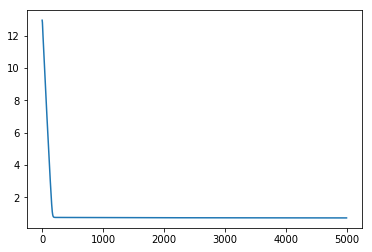

In [121]:
#目的関数のプロット
plt.plot(LoR.loss)
plt.show()

# 検証

## 【学習と推定】

機械学習スクラッチ入門のSprintで用意したirisデータセットのvirgicolorとvirginicaの2値分類に対してスクラッチ実装の学習と推定を行う。

scikit-learnによる実装と比べ、正しく動いているかを確認する。
AccuracyやPrecision、Recallなどの指標値はscikit-learnを使用する。

In [324]:
#データセットの読み込み
from sklearn.datasets import load_iris
iris = load_iris()

data = pd.DataFrame(iris.data, columns=['sepal_length', 'sepal_width', 'petal_length', 'petal_width'])
target = pd.DataFrame(iris.target, columns=['Species'])
df_0 = pd.concat([data, target], axis=1)

df_0.head()

,sepal_length,sepal_width,petal_length,petal_width,Species
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0


In [325]:
#ターゲット：virgicolorとvirginica、特徴量：sepal_lengthとpetal_lengthを抜き出す

df = df_0.query("not Species == 0").iloc[:,[0,2,4]]
df = df.reset_index(drop=True) 
df.head()

,sepal_length,petal_length,Species
0,7.0,4.7,1
1,6.4,4.5,1
2,6.9,4.9,1
3,5.5,4.0,1
4,6.5,4.6,1


In [342]:
#データセット分割
from sklearn.model_selection import train_test_split

X = df.iloc[:,[0,1]].values
y = df["Species"].replace([1,2], [0,1]).values

(X_train, X_test, y_train, y_test) = train_test_split(X, y, test_size=0.25, random_state=5,) #シードも設定しておく

print("X_train", np.shape(X_train))
print("X_test", np.shape(X_test))
print("Y_train", np.shape(y_train))
print("Y_test", np.shape(y_test))

X_train (75, 2)
X_test (25, 2)
Y_train (75,)
Y_test (25,)


In [343]:
# 正規化
from sklearn.preprocessing import StandardScaler

#X_trainのパラメータを計算
sc = StandardScaler()
sc.fit(X_train)
X_train = sc.transform(X_train)
X_test = sc.transform(X_test)

In [344]:
#オフィシャル　ロジスティック回帰
from sklearn.linear_model import LogisticRegression

official_lr = LogisticRegression()
official_lr.fit(X_train, y_train)  #訓練

official_Ir_pr = official_lr.predict(X_test)   #予測
print(official_Ir_pr)

[1 0 0 0 1 0 0 0 0 0 1 0 1 0 1 0 0 1 0 1 1 0 1 0 0]


In [345]:
#スクラッチで検証
original_lr = ScratchLogisticRegression(num_iter=12000, lr=0.001, lam=2, bias=False)
original_lr.fit(X_train, y_train, X_test, y_test)  #訓練

original_Ir_pr = original_lr.predict_proba(X_test)   #予測
print(original_Ir_pr)


[1 0 0 0 1 0 0 0 0 0 1 0 1 0 1 0 0 1 0 1 1 0 1 0 0]


In [346]:
#スコア
from sklearn import metrics

official_list = [metrics.accuracy_score(y_test, official_Ir_pr),
           metrics.precision_score(y_test, official_Ir_pr), 
           metrics.recall_score(y_test, official_Ir_pr),
           metrics.f1_score(y_test, official_Ir_pr) ]

original_list = [metrics.accuracy_score(y_test, original_Ir_pr),
           metrics.precision_score(y_test, original_Ir_pr), 
           metrics.recall_score(y_test, original_Ir_pr),
           metrics.f1_score(y_test, original_Ir_pr) ]

print("オフィシャル", official_list)
print("オリジナル　", original_list)

オフィシャル [0.92, 0.8888888888888888, 0.8888888888888888, 0.8888888888888888]
オリジナル　 [0.92, 0.8888888888888888, 0.8888888888888888, 0.8888888888888888]


## 【学習曲線のプロット】

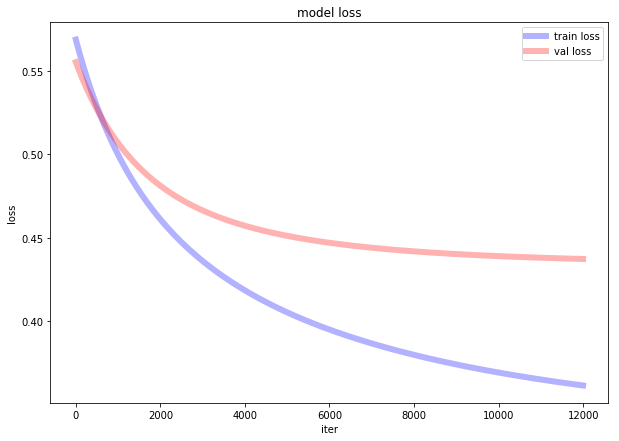

In [347]:
#関学習曲線　関数の定義
def plot_loss(loss, val_loss):
    """
    self.loss, self.val_lossを受け取ってプロットする関数
    """
    plt.figure(figsize=(10,7))
    plt.title("model loss")
    plt.ylabel("loss")
    plt.xlabel("iter")
    plt.plot(loss, color="b", linewidth=6, alpha=0.3, label="train loss")
    plt.plot(val_loss, color="r", linewidth=6, alpha=0.3, label="val loss")
    plt.legend()
    plt.show()

loss = original_lr.loss
val_loss = original_lr.val_loss
plot_loss(loss, val_loss)

## 【決定領域の可視化】


In [332]:
from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches

def decision_region(X, y, model, step=0.01, title='decision region', xlabel='xlabel', ylabel='ylabel', target_names=['versicolor', 'virginica']):
    """
    2値分類を2次元の特徴量で学習したモデルの決定領域を描く。
    背景の色が学習したモデルによる推定値から描画される。
    散布図の点は訓練データまたは検証データである。

    Parameters
    ----------------
    X : ndarray, shape(n_samples, 2)
        特徴量
    y : ndarray, shape(n_samples,)
        ラベル
    model : object
        学習したモデルのインスンタスを入れる
    step : float, (default : 0.1)
        推定値を計算する間隔を設定する
    title : str
        グラフのタイトルの文章を与える
    xlabel, ylabel : str
        軸ラベルの文章を与える
    target_names= : list of str
        凡例の一覧を与える
    """
    # setting
    scatter_color = ['red', 'blue']
    contourf_color = ['pink', 'skyblue']
    n_class = 2

    # pred
    mesh_f0, mesh_f1  = np.meshgrid(np.arange(np.min(X[:,0])-0.5, np.max(X[:,0])+0.5, step), np.arange(np.min(X[:,1])-0.5, np.max(X[:,1])+0.5, step))
    mesh = np.c_[np.ravel(mesh_f0),np.ravel(mesh_f1)]
    y_pred = model.predict(mesh).reshape(mesh_f0.shape)

    # plot
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.contourf(mesh_f0, mesh_f1, y_pred, n_class-1, cmap=ListedColormap(contourf_color))
    plt.contour(mesh_f0, mesh_f1, y_pred, n_class-1, colors='y', linewidths=3, alpha=0.5)
    for i, target in enumerate(set(y)):
        plt.scatter(X[y==target][:, 0], X[y==target][:, 1], s=80, color=scatter_color[i], label=target_names[i], marker='o')
    patches = [mpatches.Patch(color=scatter_color[i], label=target_names[i]) for i in range(n_class)]
    plt.legend(handles=patches)
    plt.legend()
    plt.show()

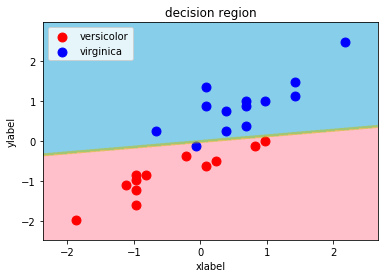

In [333]:
decision_region(X_test, y_test, official_lr)

In [334]:
#スクラッチ用にカスタマイズ（predict_probaの部分）
from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches

def scratch_decision_region(X, y, model, step=0.01, title='decision region', xlabel='xlabel', ylabel='ylabel', target_names=['versicolor', 'virginica']):
    """
    2値分類を2次元の特徴量で学習したモデルの決定領域を描く。
    背景の色が学習したモデルによる推定値から描画される。
    散布図の点は訓練データまたは検証データである。

    Parameters
    ----------------
    X : ndarray, shape(n_samples, 2)
        特徴量
    y : ndarray, shape(n_samples,)
        ラベル
    model : object
        学習したモデルのインスンタスを入れる
    step : float, (default : 0.1)
        推定値を計算する間隔を設定する
    title : str
        グラフのタイトルの文章を与える
    xlabel, ylabel : str
        軸ラベルの文章を与える
    target_names= : list of str
        凡例の一覧を与える
    """
    # setting
    scatter_color = ['red', 'blue']
    contourf_color = ['pink', 'skyblue']
    n_class = 2

    # pred
    mesh_f0, mesh_f1  = np.meshgrid(np.arange(np.min(X[:,0])-0.5, np.max(X[:,0])+0.5, step), np.arange(np.min(X[:,1])-0.5, np.max(X[:,1])+0.5, step))
    mesh = np.c_[np.ravel(mesh_f0),np.ravel(mesh_f1)]
    y_pred = model.predict_proba(mesh).reshape(mesh_f0.shape)

    # plot
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.contourf(mesh_f0, mesh_f1, y_pred, n_class-1, cmap=ListedColormap(contourf_color))
    plt.contour(mesh_f0, mesh_f1, y_pred, n_class-1, colors='y', linewidths=3, alpha=0.5)
    for i, target in enumerate(set(y)):
        plt.scatter(X[y==target][:, 0], X[y==target][:, 1], s=80, color=scatter_color[i], label=target_names[i], marker='o')
    patches = [mpatches.Patch(color=scatter_color[i], label=target_names[i]) for i in range(n_class)]
    plt.legend(handles=patches)
    plt.legend()
    plt.show()

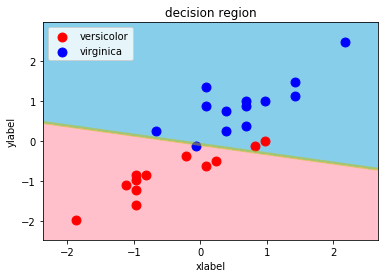

In [335]:
#スクラッチの可視化
scratch_decision_region(X_test, y_test, original_lr)

## 【問題9】（アドバンス課題）重みの保存

検証が容易になるように、学習した重みを保存および読み込みができるようにする。
pickleモジュールやNumPyのnp.savezを利用する。

In [230]:
#Pickleを使用した保存

with open('pickles/ScratchLogisticRegression.pickle', mode='wb') as f:
    pickle.dump(original_lr.coef_, f)
print(original_lr.coef_)

[-1.11188180e-04  3.64125217e-01  1.69364107e+00]


In [231]:
with open('pickles/ScratchLogisticRegression.pickle', mode='rb') as f:
    pick = pickle.load(f)

print(pick)

[-1.11188180e-04  3.64125217e-01  1.69364107e+00]


In [241]:
#クラス組み込みの関数を呼び出す。
original_lr.save_coef('pickles/ScratchLogisticRegression_01.pickle')

coef File Saved


In [243]:
#重みファイルの読み込み
load_lr = ScratchLogisticRegression()
load_lr.load_coef('pickles/ScratchLogisticRegression_01.pickle')  #重みファイル読み込み

load_Ir_pr = load_lr.predict_proba(X_test)   #予測
print("読み込み：", load_Ir_pr)
print("オリジナル", original_Ir_pr)

coef File Loaded
読み込み： [1 1 0 1 1 1 1 0 0 0 1 0 0 1 0 1 1 0 1 0 1 0 0 0 1]
オリジナル [1 1 0 1 1 1 1 0 0 0 1 0 0 1 0 1 1 0 1 0 1 0 0 0 1]


以上

# 【補足】 正則化について

ロジスティック回帰について、多項回帰ももちろん可能であるが、オーバーフィッティング、アンダーフィッティングのリスクが生じる。

オーバーフィッティングでもアンダーフィッティングでもない、汎用性があってかつ精度の高いモデルを作るためには、余計な説明変数を減らしたり、必要な説明変数を増やしたりする他、正則化 (Regularization)という方法がある。

θの値を十分小さくしてしまえば、説明変数xがどんな多項式であっても、その説明変数の予測値hθ(x)への影響を小さくできるからオーバーフィットしにくくなる、という考え。

正則化項が目的関数J(θ)に入ることにより、θの値を大きく取ると目的関数が最小値に近づけないように設計されている。

なお、θ0は説明変数xの重み付けをしない、切片 (Intercept)項なので、正則化しなくて良い。

In [378]:
# 正則化効果の確認

#サンプルデータ
X = np.array([[2,4], [1,3], [4,6], [3,5]])
y = np.array([0,1,0,1])

#線形回帰を行う際に、wx0のバイアス項を新規にデータに加える
bias = np.ones(X.shape[0]).reshape(X.shape[0],1)
X = np.concatenate([bias, X], 1)

print(X)
#暫定のシータ値を生成する
theta = np.full(X.shape[1], 0.5)

#暫定シータ値をもとに仮定値を生成する
h = np.dot(theta, X.T)
g = 1/(1+ np.exp(-h))

print("h=", h)
print("g=", g)

[[1. 2. 4.]
 [1. 1. 3.]
 [1. 4. 6.]
 [1. 3. 5.]]
h= [3.5 2.5 5.5 4.5]
g= [0.97068777 0.92414182 0.99592986 0.98901306]


In [379]:
#クロスエントロピー損失関数
inside_sigma = (-y)*np.log(g) - (1 - y)*np.log(1 - g)
cross = np.sum(inside_sigma)/X.shape[0]

print("y =                          ", y)
print("-y=                          ", -y)
print("np.log(g)=               ", np.log(g))
print("(-y)*np.log(g)           ", (-y)*np.log(g))
print("1-y=                        ", 1-y)
print("np.log(1-g)=            ", np.log(1 - g))
print("(1 - y)*np.log(1 - g)  ", (1 - y)*np.log(1 - g))
print("inside sigma=          ", inside_sigma)
print("cross=", cross)

y =                           [0 1 0 1]
-y=                           [ 0 -1  0 -1]
np.log(g)=                [-0.02975042 -0.07888973 -0.00407844 -0.01104774]
(-y)*np.log(g)            [-0.          0.07888973 -0.          0.01104774]
1-y=                         [1 0 1 0]
np.log(1-g)=             [-3.52975042 -2.57888973 -5.50407844 -4.51104774]
(1 - y)*np.log(1 - g)   [-3.52975042 -0.         -5.50407844 -0.        ]
inside sigma=           [3.52975042 0.07888973 5.50407844 0.01104774]
cross= 2.280941585171089


In [380]:
#正則化項
lam = 1
Reg = lam*np.sum(theta**2)/(2*X.shape[0])

print("theta**2", theta**2)
print("sum      ", np.sum(theta**2))
print("midi      ", np.sum(theta**2)/(2*X.shape[0]))
print("Reg      ", Reg)

theta**2 [0.25 0.25 0.25]
sum       0.75
midi       0.09375
Reg       0.09375


In [381]:
#目的関数
print(cross + Reg)

2.374691585171089


In [382]:
#シータ更新
lr = 0.1
error = g - y
error_calc = error.reshape(-1,1)*X   #偏微分
error_sum = error_calc.sum(axis=0)    #特徴量ごとに足す
theta[0] = theta[0] - lr*(error_sum[0]/X.shape[0])
theta[1:] = theta[1:] - lr*((error_sum[1:]/X.shape[0]) + (lam*np.sum(theta[1:])/X.shape[0]))
errorlist = error_sum[1:]/X.shape[0]
reglist = lam*theta[1:]/X.shape[0]
print("error", errorlist)
print("leglist", reglist)
print("Newθ", theta)
 

error [1.45406899 2.39395525]
leglist [0.08239828 0.05890112]
Newθ [0.45300569 0.3295931  0.23560448]


In [383]:
#2回目
#暫定シータ値をもとに仮定値を生成する
h = np.dot(theta, X.T)
g = 1/(1+ np.exp(-h))

print("h=", h)
print("g=", g)

#クロスエントロピー損失関数
inside_sigma = (-y)*np.log(g) - (1 - y)*np.log(1 - g)
cross = np.sum(inside_sigma)/X.shape[0]

print("y =                          ", y)
print("-y=                          ", -y)
print("np.log(g)=               ", np.log(g))
print("(-y)*np.log(g)           ", (-y)*np.log(g))
print("1-y=                        ", 1-y)
print("np.log(1-g)=            ", np.log(1 - g))
print("(1 - y)*np.log(1 - g)  ", (1 - y)*np.log(1 - g))
print("inside sigma=          ", inside_sigma)
print("cross=", cross)

#正則化項
Reg = lam*np.sum(theta**2)/(2*X.shape[0])

print("theta**2", theta**2)
print("sum      ", np.sum(theta**2))
print("midi      ", np.sum(theta**2)/(2*X.shape[0]))
print("Reg      ", Reg)

#目的関数
print("cross + Reg", cross + Reg)

#シータ更新
error = g - y
error_calc = error.reshape(-1,1)*X   #偏微分
error_sum = error_calc.sum(axis=0)    #特徴量ごとに足す
theta[0] = theta[0] - lr*(error_sum[0]/X.shape[0])
theta[1:] = theta[1:] - lr*((error_sum[1:]/X.shape[0]) + (lam*theta[1:]/X.shape[0]))
print("New Theta:", theta)

h= [2.05460979 1.48941221 3.18500494 2.61980736]
g= [0.88641258 0.81599003 0.96026607 0.93212552]
y =                           [0 1 0 1]
-y=                           [ 0 -1  0 -1]
np.log(g)=                [-0.12057277 -0.20335314 -0.04054488 -0.0702878 ]
(-y)*np.log(g)            [-0.          0.20335314 -0.          0.0702878 ]
1-y=                         [1 0 1 0]
np.log(1-g)=             [-2.17518255 -1.69276535 -3.22554982 -2.69009516]
(1 - y)*np.log(1 - g)   [-2.17518255 -0.         -3.22554982 -0.        ]
inside sigma=           [2.17518255 0.20335314 3.22554982 0.0702878 ]
cross= 1.4185933261957868
theta**2 [0.20521415 0.10863161 0.05550947]
sum       0.36935523327768094
midi       0.04616940415971012
Reg       0.04616940415971012
cross + Reg 1.4647627303554969
New Theta: [0.41313583 0.19069687 0.01931825]


In [384]:
#３回目
#暫定シータ値をもとに仮定値を生成する
h = np.dot(theta, X.T)
g = 1/(1+ np.exp(-h))

print("h=", h)
print("g=", g)

#クロスエントロピー損失関数
inside_sigma = (-y)*np.log(g) - (1 - y)*np.log(1 - g)
cross = np.sum(inside_sigma)/X.shape[0]

print("y =                          ", y)
print("-y=                          ", -y)
print("np.log(g)=               ", np.log(g))
print("(-y)*np.log(g)           ", (-y)*np.log(g))
print("1-y=                        ", 1-y)
print("np.log(1-g)=            ", np.log(1 - g))
print("(1 - y)*np.log(1 - g)  ", (1 - y)*np.log(1 - g))
print("inside sigma=          ", inside_sigma)
print("cross=", cross)

#正則化項
Reg = lam*np.sum(theta**2)/(2*X.shape[0])

print("theta**2", theta**2)
print("sum      ", np.sum(theta**2))
print("midi      ", np.sum(theta**2)/(2*X.shape[0]))
print("Reg      ", Reg)

#目的関数
print("cross + Reg", cross + Reg)

#シータ更新
error = g - y
error_calc = error.reshape(-1,1)*X   #偏微分
error_sum = error_calc.sum(axis=0)    #特徴量ごとに足す
theta[0] = theta[0] - lr*(error_sum[0]/X.shape[0])
theta[1:] = theta[1:] - lr*((error_sum[1:]/X.shape[0]) + (lam*theta[1:]/X.shape[0]))
print("New Theta:", theta)

h= [0.87180258 0.66178746 1.29183283 1.08181771]
g= [0.70512064 0.6596618  0.78445725 0.74683781]
y =                           [0 1 0 1]
-y=                           [ 0 -1  0 -1]
np.log(g)=                [-0.34938637 -0.416028   -0.2427632  -0.29190723]
(-y)*np.log(g)            [-0.          0.416028   -0.          0.29190723]
1-y=                         [1 0 1 0]
np.log(1-g)=             [-1.22118895 -1.07781546 -1.53459603 -1.37372494]
(1 - y)*np.log(1 - g)   [-1.22118895 -0.         -1.53459603 -0.        ]
inside sigma=           [1.22118895 0.416028   1.53459603 0.29190723]
cross= 0.8659300532318037
theta**2 [0.17068122 0.0363653  0.00037319]
sum       0.2074197075666417
midi       0.02592746344583021
Reg       0.02592746344583021
cross + Reg 0.8918575166776339
New Theta: [ 0.39073389  0.09972331 -0.11217472]


In [385]:
#正則化無しパターン

#暫定のシータ値をリセットする
theta = np.full(X.shape[1], 0.5)

#暫定シータ値をもとに仮定値を生成する
h = np.dot(theta, X.T)
g = 1/(1+ np.exp(-h))

print("h=", h)
print("g=", g)

#クロスエントロピー損失関数
inside_sigma = (-y)*np.log(g) - (1 - y)*np.log(1 - g)
cross = np.sum(inside_sigma)/X.shape[0]

print("(-y)*np.log(g)           ", (-y)*np.log(g))
print("(1 - y)*np.log(1 - g)  ", (1 - y)*np.log(1 - g))
print("inside sigma=          ", inside_sigma)
print("cross=", cross)

#シータ更新
error = g - y
error_calc = error.reshape(-1,1)*X   #偏微分
error_sum = error_calc.sum(axis=0)    #特徴量ごとに足す
theta[0] = theta[0] - lr*(error_sum[0]/X.shape[0])
theta[1:] = theta[1:] - lr*((error_sum[1:]/X.shape[0]))
print("New Theta:", theta)

h= [3.5 2.5 5.5 4.5]
g= [0.97068777 0.92414182 0.99592986 0.98901306]
(-y)*np.log(g)            [-0.          0.07888973 -0.          0.01104774]
(1 - y)*np.log(1 - g)   [-3.52975042 -0.         -5.50407844 -0.        ]
inside sigma=           [3.52975042 0.07888973 5.50407844 0.01104774]
cross= 2.280941585171089
New Theta: [0.45300569 0.3545931  0.26060448]


In [386]:
#正則化無しパターン2回目

#暫定シータ値をもとに仮定値を生成する
h = np.dot(theta, X.T)
g = 1/(1+ np.exp(-h))

print("h=", h)
print("g=", g)

#クロスエントロピー損失関数
inside_sigma = (-y)*np.log(g) - (1 - y)*np.log(1 - g)
cross = np.sum(inside_sigma)/X.shape[0]

print("(-y)*np.log(g)           ", (-y)*np.log(g))
print("(1 - y)*np.log(1 - g)  ", (1 - y)*np.log(1 - g))
print("inside sigma=          ", inside_sigma)
print("cross=", cross)

#シータ更新
error = g - y
error_calc = error.reshape(-1,1)*X   #偏微分
error_sum = error_calc.sum(axis=0)    #特徴量ごとに足す
theta[0] = theta[0] - lr*(error_sum[0]/X.shape[0])
theta[1:] = theta[1:] - lr*((error_sum[1:]/X.shape[0]))
print("New Theta:", theta)

h= [2.20460979 1.58941221 3.43500494 2.81980736]
g= [0.90066271 0.83053339 0.9687808  0.94373684]
(-y)*np.log(g)            [-0.          0.18568715 -0.          0.05790792]
(1 - y)*np.log(1 - g)   [-2.30923423 -0.         -3.46672185 -0.        ]
inside sigma=           [2.30923423 0.18568715 3.46672185 0.05790792]
cross= 1.5048877882230711
New Theta: [0.41191284 0.22113829 0.04496398]


In [387]:
#正則化無しパターン３回目

#暫定シータ値をもとに仮定値を生成する
h = np.dot(theta, X.T)
g = 1/(1+ np.exp(-h))

print("h=", h)
print("g=", g)

#クロスエントロピー損失関数
inside_sigma = (-y)*np.log(g) - (1 - y)*np.log(1 - g)
cross = np.sum(inside_sigma)/X.shape[0]

print("(-y)*np.log(g)           ", (-y)*np.log(g))
print("(1 - y)*np.log(1 - g)  ", (1 - y)*np.log(1 - g))
print("inside sigma=          ", inside_sigma)
print("cross=", cross)

#シータ更新
error = g - y
error_calc = error.reshape(-1,1)*X   #偏微分
error_sum = error_calc.sum(axis=0)    #特徴量ごとに足す
theta[0] = theta[0] - lr*(error_sum[0]/X.shape[0])
theta[1:] = theta[1:] - lr*((error_sum[1:]/X.shape[0]))
print("New Theta:", theta)

h= [1.03404532 0.76794306 1.56624985 1.30014759]
g= [0.73769941 0.68307577 0.82724834 0.78585982]
(-y)*np.log(g)            [-0.          0.38114949 -0.          0.24097685]
(1 - y)*np.log(1 - g)   [-1.33826416 -0.         -1.75590019 -0.        ]
inside sigma=           [1.33826416 0.38114949 1.75590019 0.24097685]
cross= 0.9290726723759862
New Theta: [ 0.38606576  0.1255121  -0.10235638]


In [388]:
#λが大きい（＝10）パターン
lam = 10
#暫定のシータ値をリセットする
theta = np.full(X.shape[1], 0.5)

#暫定シータ値をもとに仮定値を生成する
h = np.dot(theta, X.T)
g = 1/(1+ np.exp(-h))

print("h=", h)
print("g=", g)

#クロスエントロピー損失関数
inside_sigma = (-y)*np.log(g) - (1 - y)*np.log(1 - g)
cross = np.sum(inside_sigma)/X.shape[0]


print("(-y)*np.log(g)           ", (-y)*np.log(g))
print("(1 - y)*np.log(1 - g)  ", (1 - y)*np.log(1 - g))
print("inside sigma=          ", inside_sigma)
print("cross=", cross)

#正則化項
Reg = lam*np.sum(theta**2)/(2*X.shape[0])

print("theta**2", theta**2)
print("sum      ", np.sum(theta**2))
print("midi      ", np.sum(theta**2)/(2*X.shape[0]))
print("Reg      ", Reg)

#目的関数
print("cross + Reg", cross + Reg)

#シータ更新
error = g - y
error_calc = error.reshape(-1,1)*X   #偏微分
error_sum = error_calc.sum(axis=0)    #特徴量ごとに足す
errorlist = error_sum[1:]/X.shape[0]
reglist = lam*theta[1:]/X.shape[0]
theta[0] = theta[0] - lr*(error_sum[0]/X.shape[0])
theta[1:] = theta[1:] - lr*((error_sum[1:]/X.shape[0]) + (lam*theta[1:]/X.shape[0]))
print("error", errorlist)
print("leglist", reglist)
print("New Theta:", theta)

h= [3.5 2.5 5.5 4.5]
g= [0.97068777 0.92414182 0.99592986 0.98901306]
(-y)*np.log(g)            [-0.          0.07888973 -0.          0.01104774]
(1 - y)*np.log(1 - g)   [-3.52975042 -0.         -5.50407844 -0.        ]
inside sigma=           [3.52975042 0.07888973 5.50407844 0.01104774]
cross= 2.280941585171089
theta**2 [0.25 0.25 0.25]
sum       0.75
midi       0.09375
Reg       0.9375
cross + Reg 3.218441585171089
error [1.45406899 2.39395525]
leglist [1.25 1.25]
New Theta: [0.45300569 0.2295931  0.13560448]


In [389]:
#λが大きいパターン2回目
#暫定シータ値をもとに仮定値を生成する
h = np.dot(theta, X.T)
g = 1/(1+ np.exp(-h))

print("h=", h)
print("g=", g)

#クロスエントロピー損失関数
inside_sigma = (-y)*np.log(g) - (1 - y)*np.log(1 - g)
cross = np.sum(inside_sigma)/X.shape[0]


print("(-y)*np.log(g)           ", (-y)*np.log(g))
print("(1 - y)*np.log(1 - g)  ", (1 - y)*np.log(1 - g))
print("inside sigma=          ", inside_sigma)
print("cross=", cross)

#正則化項
Reg = lam*np.sum(theta**2)/(2*X.shape[0])

print("theta**2", theta**2)
print("sum      ", np.sum(theta**2))
print("midi      ", np.sum(theta**2)/(2*X.shape[0]))
print("Reg      ", Reg)

#目的関数
print("cross + Reg", cross + Reg)

#シータ更新
error = g - y
error_calc = error.reshape(-1,1)*X   #偏微分
error_sum = error_calc.sum(axis=0)    #特徴量ごとに足す
errorlist = error_sum[1:]/X.shape[0]
reglist = lam*theta[1:]/X.shape[0]
theta[0] = theta[0] - lr*(error_sum[0]/X.shape[0])
theta[1:] = theta[1:] - lr*((error_sum[1:]/X.shape[0]) + (lam*theta[1:]/X.shape[0]))

print("error", errorlist)
print("leglist", reglist)
print("New Theta:", theta)

h= [1.45460979 1.08941221 2.18500494 1.81980736]
g= [0.81070687 0.74827102 0.89889484 0.86054301]
(-y)*np.log(g)            [-0.          0.28999004 -0.          0.15019168]
(1 - y)*np.log(1 - g)   [-1.66445852 -0.         -2.29159416 -0.        ]
inside sigma=           [1.66445852 0.28999004 2.29159416 0.15019168]
cross= 1.099058600040032
theta**2 [0.20521415 0.05271299 0.01838857]
sum       0.2763157181636969
midi       0.03453946477046211
Reg       0.3453946477046211
cross + Reg 1.444453247744653
error [1.13672329 1.79593117]
leglist [0.57398275 0.33901119]
New Theta: [ 0.42004529  0.0585225  -0.07788976]


In [390]:
#λが大きいパターン３回目
#暫定シータ値をもとに仮定値を生成する
h = np.dot(theta, X.T)
g = 1/(1+ np.exp(-h))

print("h=", h)
print("g=", g)

#クロスエントロピー損失関数
inside_sigma = (-y)*np.log(g) - (1 - y)*np.log(1 - g)
cross = np.sum(inside_sigma)/X.shape[0]


print("(-y)*np.log(g)           ", (-y)*np.log(g))
print("(1 - y)*np.log(1 - g)  ", (1 - y)*np.log(1 - g))
print("inside sigma=          ", inside_sigma)
print("cross=", cross)

#正則化項
Reg = lam*np.sum(theta**2)/(2*X.shape[0])

print("theta**2", theta**2)
print("sum      ", np.sum(theta**2))
print("midi      ", np.sum(theta**2)/(2*X.shape[0]))
print("Reg      ", Reg)

#目的関数
print("cross + Reg", cross + Reg)

#シータ更新
error = g - y
error_calc = error.reshape(-1,1)*X   #偏微分
error_sum = error_calc.sum(axis=0)    #特徴量ごとに足す
errorlist = error_sum[1:]/X.shape[0]
reglist = lam*theta[1:]/X.shape[0]
theta[0] = theta[0] - lr*(error_sum[0]/X.shape[0])
theta[1:] = theta[1:] - lr*((error_sum[1:]/X.shape[0]) + (lam*theta[1:]/X.shape[0]))

print("error", errorlist)
print("leglist", reglist)
print("New Theta:", theta)

h= [0.22553124 0.24489851 0.18679672 0.20616398]
g= [0.55614503 0.56092045 0.54656386 0.55135921]
(-y)*np.log(g)            [-0.          0.57817618 -0.          0.59536876]
(1 - y)*np.log(1 - g)   [-0.81225742 -0.         -0.79090084 -0.        ]
inside sigma=           [0.81225742 0.57817618 0.79090084 0.59536876]
cross= 0.6941757967279553
theta**2 [0.17643805 0.00342488 0.00606681]
sum       0.185929745984828
midi       0.0232412182481035
Reg       0.232412182481035
cross + Reg 0.9265879792089903
error [0.3783859  0.48588018]
leglist [ 0.14630624 -0.1947244 ]
New Theta: [ 0.41467058  0.00605328 -0.10700534]


In [391]:
#λが大きいパターン４回目
#暫定シータ値をもとに仮定値を生成する
h = np.dot(theta, X.T)
g = 1/(1+ np.exp(-h))

print("h=", h)
print("g=", g)

#クロスエントロピー損失関数
inside_sigma = (-y)*np.log(g) - (1 - y)*np.log(1 - g)
cross = np.sum(inside_sigma)/X.shape[0]


print("(-y)*np.log(g)           ", (-y)*np.log(g))
print("(1 - y)*np.log(1 - g)  ", (1 - y)*np.log(1 - g))
print("inside sigma=          ", inside_sigma)
print("cross=", cross)

#正則化項
Reg = lam*np.sum(theta**2)/(2*X.shape[0])

print("theta**2", theta**2)
print("sum      ", np.sum(theta**2))
print("midi      ", np.sum(theta**2)/(2*X.shape[0]))
print("Reg      ", Reg)

#目的関数
print("cross + Reg", cross + Reg)

#シータ更新
error = g - y
error_calc = error.reshape(-1,1)*X   #偏微分
error_sum = error_calc.sum(axis=0)    #特徴量ごとに足す
errorlist = error_sum[1:]/X.shape[0]
reglist = lam*theta[1:]/X.shape[0]
theta[0] = theta[0] - lr*(error_sum[0]/X.shape[0])
theta[1:] = theta[1:] - lr*((error_sum[1:]/X.shape[0]) + (lam*theta[1:]/X.shape[0]))

print("error", errorlist)
print("leglist", reglist)
print("New Theta:", theta)

h= [-0.00124421  0.09970785 -0.20314832 -0.10219626]
g= [0.49968895 0.52490633 0.44938686 0.47447315]
(-y)*np.log(g)            [-0.          0.64453545 -0.          0.74555025]
(1 - y)*np.log(1 - g)   [-0.69252527 -0.         -0.59672283 -0.        ]
inside sigma=           [0.69252527 0.64453545 0.59672283 0.74555025]
cross= 0.6698334507145898
theta**2 [1.71951690e-01 3.66422250e-05 1.14501424e-02]
sum       0.18343847422370865
midi       0.02292980927796358
Reg       0.2292980927796358
cross + Reg 0.8991315434942255
error [0.18631278 0.16054043]
leglist [ 0.01513321 -0.26751335]
New Theta: [ 0.4159592  -0.01409132 -0.09630805]


In [392]:
#λが大きいパターン５回目
#暫定シータ値をもとに仮定値を生成する
h = np.dot(theta, X.T)
g = 1/(1+ np.exp(-h))

print("h=", h)
print("g=", g)

#クロスエントロピー損失関数
inside_sigma = (-y)*np.log(g) - (1 - y)*np.log(1 - g)
cross = np.sum(inside_sigma)/X.shape[0]


print("(-y)*np.log(g)           ", (-y)*np.log(g))
print("(1 - y)*np.log(1 - g)  ", (1 - y)*np.log(1 - g))
print("inside sigma=          ", inside_sigma)
print("cross=", cross)

#正則化項
Reg = lam*np.sum(theta**2)/(2*X.shape[0])

print("theta**2", theta**2)
print("sum      ", np.sum(theta**2))
print("midi      ", np.sum(theta**2)/(2*X.shape[0]))
print("Reg      ", Reg)

#目的関数
print("cross + Reg", cross + Reg)

#シータ更新
error = g - y
error_calc = error.reshape(-1,1)*X   #偏微分
error_sum = error_calc.sum(axis=0)    #特徴量ごとに足す
errorlist = error_sum[1:]/X.shape[0]
reglist = lam*theta[1:]/X.shape[0]
theta[0] = theta[0] - lr*(error_sum[0]/X.shape[0])
theta[1:] = theta[1:] - lr*((error_sum[1:]/X.shape[0]) + (lam*theta[1:]/X.shape[0]))

print("error", errorlist)
print("leglist", reglist)
print("New Theta:", theta)

h= [ 0.00254438  0.11294374 -0.21825435 -0.10785498]
g= [0.50063609 0.52820596 0.44565198 0.47306236]
(-y)*np.log(g)            [-0.          0.638269   -0.          0.74852806]
(1 - y)*np.log(1 - g)   [-0.69442018 -0.         -0.5899626  -0.        ]
inside sigma=           [0.69442018 0.638269   0.5899626  0.74852806]
cross= 0.6677949575435371
theta**2 [0.17302205 0.00019857 0.00927524]
sum       0.18249585885419903
midi       0.02281198235677488
Reg       0.2281198235677488
cross + Reg 0.895914781111286
error [0.18281829 0.15659649]
leglist [-0.03522829 -0.24077012]
New Theta: [ 0.41727029 -0.02885032 -0.08789068]


## まとめ

- λの値が大きいと、シータの更新式において特徴量の差分が大きくなるため、ゼロに近づくスピードが速くなる
- クロスエントロピー損失関数と正則化項は共に減少していくが、減り方に差があるようだ